## Load data and check data structure (colab environment)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/data\ -\ MoMD

meta_Office_Products.jsonl  Office_Products.jsonl


In [ ]:
import pandas as pd

PRODUCTS_PATH = 'drive/MyDrive/data - MoMD'

meta_df = pd.read_json(PRODUCTS_PATH + '/meta_Office_Products.jsonl', lines=True, chunksize=10000).__next__()

In [ ]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    9910 non-null   object 
 1   title            10000 non-null  object 
 2   average_rating   10000 non-null  float64
 3   rating_number    10000 non-null  int64  
 4   features         10000 non-null  object 
 5   description      10000 non-null  object 
 6   price            5215 non-null   float64
 7   images           10000 non-null  object 
 8   videos           10000 non-null  object 
 9   store            9881 non-null   object 
 10  categories       10000 non-null  object 
 11  details          10000 non-null  object 
 12  parent_asin      10000 non-null  object 
 13  bought_together  0 non-null      float64
 14  subtitle         47 non-null     object 
 15  author           12 non-null     object 
dtypes: float64(3), int64(1), object(12)
memory usage: 1.2+ MB


In [ ]:
meta_df.head(1)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Office Products,Alliance Rubber 07706 Non-Latex Brites File Ba...,4.5,665,[REUSABLE: These colored rubber bands are stre...,[Alliance Rubber Brites File Bands are durable...,2.68,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'AMUU rubber bands Large 50 Pack 5 ...,Alliance,"[Office Products, Office & School Supplies, Ta...",{'Manufacturer': 'Alliance Rubber Company Inc....,B001S28Q4Q,NaN,NaN,NaN


In [ ]:
review_df = pd.read_json(PRODUCTS_PATH + '/Office_Products.jsonl', lines=True, chunksize=10000).__next__()

In [ ]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             10000 non-null  int64         
 1   title              10000 non-null  object        
 2   text               10000 non-null  object        
 3   images             10000 non-null  object        
 4   asin               10000 non-null  object        
 5   parent_asin        10000 non-null  object        
 6   user_id            10000 non-null  object        
 7   timestamp          10000 non-null  datetime64[ns]
 8   helpful_vote       10000 non-null  int64         
 9   verified_purchase  10000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 713.0+ KB


In [ ]:
review_df.head(1)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Pretty & I love it!,Lovely ink. Writes well. The right amount of w...,[],B01AHHL4X2,B01MZ3SD2X,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-03-04 14:15:45.945,0,True


## Load spark from jsonl

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import get_json_object, from_json, regexp_replace, col
from pyspark.sql.types import *

spark = SparkSession.builder.appName('Office').getOrCreate()

review_df = spark.read.json(PRODUCTS_PATH + '/Office_Products.jsonl')

In [ ]:
meta_schema = StructType([
    StructField("main_category", StringType(), True),
    StructField("title", StringType(), True),
    StructField("average_rating", DoubleType(), True),
    StructField("rating_number", LongType(), True),
    StructField("features", ArrayType(StringType()), True),
    StructField("description", ArrayType(StringType()), True),
    StructField("price", DoubleType(), True),
    StructField("images", ArrayType(MapType(StringType(), StringType())), True),
    StructField("videos", ArrayType(MapType(StringType(), StringType())), True),
    StructField("store", StringType(), True),
    StructField("categories", ArrayType(StringType()), True),

    StructField("details", StringType(), True),

    StructField("parent_asin", StringType(), True),
    StructField("bought_together", DoubleType(), True),
    StructField("subtitle", StringType(), True),
    StructField("author", StringType(), True),
])

raw_meta_df = spark.read.text(PRODUCTS_PATH + "/meta_Office_Products.jsonl")

meta_df = (
    raw_meta_df
    .select(from_json(col("value"), meta_schema).alias("data"))
    .select("data.*")
)

## Show schema

In [ ]:
meta_df.printSchema()

root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)
 |-- videos: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)
 |-- store: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- bought_together: double (nullable = true)
 |-- subtitle: string (nu

In [ ]:
review_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



## Data quality

### Check null

In [ ]:
total_review = review_df.count()
total_meta = meta_df.count()

In [ ]:
from pyspark.sql.functions import col, when, count, lit, concat, round, sum

null_review_counts = review_df.select([
    sum(
        col(c).isNull().cast('int')
    ).alias(c)
    for c in review_df.columns
])

null_review_counts.select([
    concat(
        col(c).cast('string'),
        lit(" ("),
        round(col(c).cast('float') * 100 / total_review, 2).cast('string'),
        lit("%)")
    ).alias(c)
    for c in review_df.columns
]).show()

+--------+------------+--------+-----------+--------+--------+---------+--------+--------+-----------------+
|    asin|helpful_vote|  images|parent_asin|  rating|    text|timestamp|   title| user_id|verified_purchase|
+--------+------------+--------+-----------+--------+--------+---------+--------+--------+-----------------+
|0 (0.0%)|    0 (0.0%)|0 (0.0%)|   0 (0.0%)|0 (0.0%)|0 (0.0%)| 0 (0.0%)|0 (0.0%)|0 (0.0%)|         0 (0.0%)|
+--------+------------+--------+-----------+--------+--------+---------+--------+--------+-----------------+



In [ ]:
null_meta_counts = meta_df.select([
    sum(
        col(c).isNull().cast('int')
    ).alias(c)
    for c in meta_df.columns
])

null_meta_counts.select([
    concat(
        col(c).cast('string'),
        lit(" ("),
        round(col(c).cast('float') * 100 / total_meta, 2).cast('string'),
        lit("%)")
    ).alias(c)
    for c in meta_df.columns
]).show()

+-------------+--------+--------------+-------------+--------+-----------+---------------+--------+--------+-------------+----------+--------+-----------+---------------+---------------+--------------+
|main_category|   title|average_rating|rating_number|features|description|          price|  images|  videos|        store|categories| details|parent_asin|bought_together|       subtitle|        author|
+-------------+--------+--------------+-------------+--------+-----------+---------------+--------+--------+-------------+----------+--------+-----------+---------------+---------------+--------------+
|23944 (3.37%)|0 (0.0%)|      0 (0.0%)|     0 (0.0%)|0 (0.0%)|   0 (0.0%)|428529 (60.31%)|0 (0.0%)|0 (0.0%)|12251 (1.72%)|  0 (0.0%)|0 (0.0%)|   0 (0.0%)|710503 (100.0%)|702873 (98.93%)|709069 (99.8%)|
+-------------+--------+--------------+-------------+--------+-----------+---------------+--------+--------+-------------+----------+--------+-----------+---------------+---------------+------

### Check NaN

In [ ]:
review_numeric_fields = ['rating', 'helpful_vote']

na_review_counts = review_df.select([
    sum(
        col(c).isNaN().cast('int')
    ).alias(c)
    for c in review_numeric_fields
])

na_review_counts.select([
    concat(
        col(c).cast('string'),
        lit(" ("),
        round(col(c).cast('float') * 100 / total_review).cast('string'),
        lit("%)")
    ).alias(c)
  for c in na_review_counts.columns
]).show()

+--------+------------+
|  rating|helpful_vote|
+--------+------------+
|0 (0.0%)|    0 (0.0%)|
+--------+------------+



In [ ]:
meta_numeric_fields = ['average_rating', 'rating_number', 'price', 'bought_together']

na_meta_counts = meta_df.select([
    sum(
        col(c).isNaN().cast('int')
    ).alias(c)
    for c in meta_numeric_fields
])

na_meta_counts.select([
    concat(
        col(c).cast('string'),
        lit(" ("),
        round(col(c).cast('float') * 100 / total_meta).cast('string'),
        lit("%)")
    ).alias(c)
    for c in na_meta_counts.columns
]).show()

+--------------+-------------+--------+---------------+
|average_rating|rating_number|   price|bought_together|
+--------------+-------------+--------+---------------+
|      0 (0.0%)|     0 (0.0%)|0 (0.0%)|       0 (0.0%)|
+--------------+-------------+--------+---------------+



### Check empty list

In [ ]:
from pyspark.sql.functions import size

review_list_fields = ['images']

empty_review_counts = review_df.select([
    sum(
        (size(col(c)) == 0).cast('int')
    ).alias(c)
    for c in review_list_fields
])

empty_review_counts.select([
    concat(
        col(c).cast('string'),
        lit(" ("),
        round(col(c).cast('float') * 100 / total_review, 2).cast('string'),
        lit("%)")
    ).alias(c)
    for c in empty_review_counts.columns
]).show()

+-----------------+
|           images|
+-----------------+
|12149163 (94.58%)|
+-----------------+



In [ ]:
from pyspark.sql.functions import size

meta_list_fields = ['features', 'description', 'images', 'videos', 'categories']

empty_meta_counts = meta_df.select([
    sum(
        (size(col(c)) == 0).cast('int')
    ).alias(c)
    for c in meta_list_fields
])

empty_meta_counts.select([
    concat(
        col(c).cast('string'),
        lit(" ("),
        round(col(c).cast('float') * 100 / total_review, 2).cast('string'),
        lit("%)")
    ).alias(c)
    for c in empty_meta_counts.columns
]).show()

+--------------+--------------+------------+--------------+-------------+
|      features|   description|      images|        videos|   categories|
+--------------+--------------+------------+--------------+-------------+
|159860 (1.24%)|288566 (2.25%)|3266 (0.03%)|505312 (3.93%)|75657 (0.59%)|
+--------------+--------------+------------+--------------+-------------+



### Check Meta parent_asin duplications

In [ ]:
total_meta != meta_df.select('parent_asin').distinct().count()

False

### Check Review duplications

In [ ]:
from pyspark.sql.functions import col

review_dup_records = review_df.groupBy('asin', 'user_id', 'timestamp').count().filter(col('count') > 1)
review_dup_records.show()

+----------+--------------------+-------------+-----+
|      asin|             user_id|    timestamp|count|
+----------+--------------------+-------------+-----+
|B012UHCYHM|AFVVC76FEX76JISS3...|1628116836423|    2|
|B07YHZLZ8P|AEK6XGWJ3SGTNIGWZ...|1576682819406|    2|
|B07B7KVCXC|AEQ4BRZQAEE7UKKOP...|1612132472541|    2|
|B07C6LWD4G|AELZBZB4NMP6LNN7M...|1536768587672|    2|
|B00XN6A6JI|AH3QNNM6B5FDM4DZZ...|1574379837373|    2|
|B00LVQMDAW|AGKDDU3Y7VHQ4AOCZ...|1517118129883|    2|
|B06XYJYYR7|AGKV2ORMQMK74NTY4...|1583761158151|    2|
|B0000C120T|AH2TLPOHOO6J7SURK...|1473957767000|    2|
|B00C0JPVGM|AGEC6NOVMDJ4ZLSTT...|1501302223555|    2|
|B07PRLCHNH|AE2FQOVSBVZWMJM76...|1615652813681|    2|
|B0019IP2GE|AG7GUINS6RD7C2YW6...|1435006402000|    2|
|B07WGV9T3C|AHJ53MFBWACTLJ3IF...|1587642092715|    2|
|B00HM9USNG|AGIKG6GPPK7AJRSGE...|1442890789000|    2|
|B01H6XZU1M|AEQ4BRZQAEE7UKKOP...|1557442660352|    2|
|B001603YXI|AHLDHIVNLWLVRDISE...|1582145026218|    2|
|B000RMS238|AFERA3XEMMGZFV4H

In [ ]:
review_dup_records.count()

111283

### Join coverage

In [ ]:
joined_df = review_df.join(
    meta_df.select("parent_asin"),
    on="parent_asin",
    how="left"
)

In [ ]:
total_matched_reviews = joined_df.filter(
    joined_df["parent_asin"].isNotNull()
).count()

In [ ]:
total_unmatched_reviews = joined_df.filter(
    joined_df["parent_asin"].isNull()
).count()

In [ ]:
matched_ratio = total_matched_reviews / total_review
matched_ratio

1.0

In [ ]:
total_unmatched_reviews

0

## User

### User count

In [ ]:
from pyspark.sql.functions import avg, count

distinct_users = review_df.groupBy('user_id').agg(
    avg('rating').alias('avg_rating'),
    count('user_id').alias('count')
)

In [ ]:
distinc_user_count = distinct_users.count()

### Number of reviews distribution

In [ ]:
distinct_users.select('count').describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|           7613158|
|   mean|1.6873040070887797|
| stddev| 2.156873070765837|
|    min|                 1|
|    max|               921|
+-------+------------------+



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
rdd = distinct_users.rdd.map(lambda x: x[2])

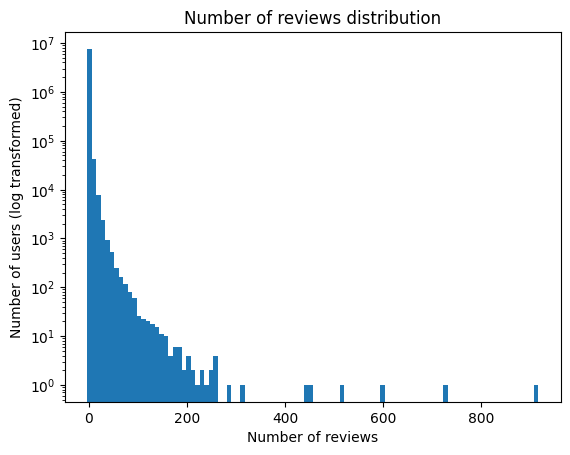

In [ ]:
bins, counts = rdd.histogram(100)
plt.bar(bins[:-1], counts, width=bins[1] - bins[0])
plt.yscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users (log transformed)')
plt.title('Number of reviews distribution')
plt.show()

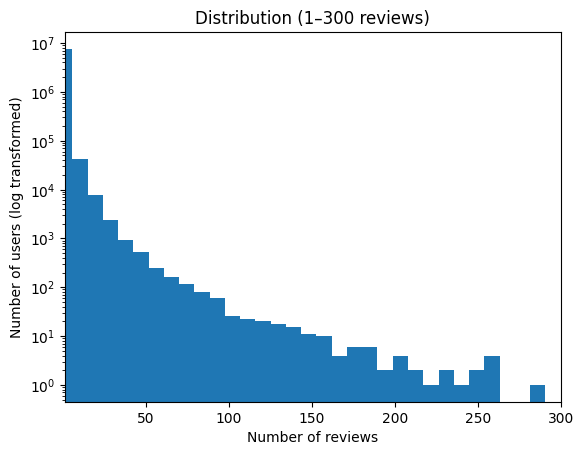

In [ ]:
plt.bar(bins[:-1], counts, width=bins[1] - bins[0])
plt.xlim(1, 300)
plt.yscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users (log transformed)')
plt.title('Distribution (1–300 reviews)')
plt.show()

### Users with only 1 review

In [ ]:
users_with_1_review = distinct_users.filter(col('count') == 1)

In [ ]:
users_with_1_review_count = users_with_1_review.count()

In [ ]:
users_with_1_review_count / distinc_user_count

0.7002484382959082

### Rating distribution

In [ ]:
rdd = distinct_users.rdd.map(lambda x: x[1])

In [ ]:
bins, counts = rdd.histogram(26)

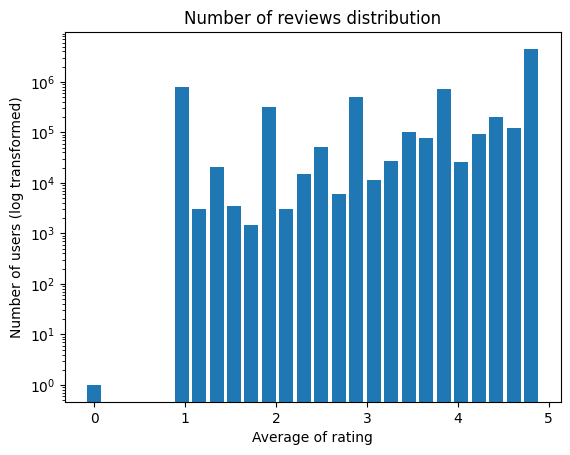

In [ ]:
plt.bar(bins[:-1], counts, width= 0.8*(bins[1] - bins[0]))
plt.yscale('log')
plt.xlabel('Average of rating')
plt.ylabel('Number of users (log transformed)')
plt.title('Number of reviews distribution')
plt.show()

In [ ]:
distinct_users.select('avg_rating').describe().show()

+-------+------------------+
|summary|        avg_rating|
+-------+------------------+
|  count|           7613158|
|   mean|4.1135565739673075|
| stddev| 1.352797117758302|
|    min|               0.0|
|    max|               5.0|
+-------+------------------+



In [ ]:
from pyspark.ml.feature import Bucketizer

splits = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

bucketizer = Bucketizer(splits=splits, inputCol="avg_rating", outputCol="rating_bucket")

rating_bucketed = bucketizer.transform(distinct_users)
rating_bucketed.groupBy('rating_bucket').count().orderBy('rating_bucket').show()

+-------------+-------+
|rating_bucket|  count|
+-------------+-------+
|          0.0|      1|
|          1.0| 835186|
|          2.0| 392012|
|          3.0| 724108|
|          4.0|1201423|
|          5.0|4460428|
+-------------+-------+

